In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import joblib

import datetime
from ngram import *
from baselines import *
from stats_utils import get_beta_dist, bayesian_ci
from error_analysis import *
import os
import fnmatch
import numpy as np
import time
import multiprocessing as mp
import re 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import inspect, os
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(0,parentdir) 
from data_generation.diff_utils import clean_and_filter

# Load Diffs and Models

### Load Models

In [7]:
m_agg = joblib.load( '../../models/aggression_regression_ngram.pkl')
m_rec = joblib.load( '../../models/recipient_ngram.pkl')

### Load annotationed diffs

In [8]:
d_b, d_r = load_cf_data()
d_annotations = tidy_labels(d_r)
d_annotated = d_annotations.drop_duplicates(subset=['rev_id'])

d_annotated['recipient'] = plurality(d_annotations['recipient'].dropna())
d_annotated['recipient_score'] = average(d_annotations['recipient'].dropna())

d_annotated['aggression'] = average(d_annotations['aggression_score'].dropna())
d_annotated['rev_timestamp'] = d_annotated['rev_timestamp'].apply(lambda x: datetime.datetime.strptime (x, "%Y-%m-%dT%H:%M:%SZ"))
d_annotated['pred_aggression_score'] =  m_agg.predict(d_annotated['clean_diff'])
d_annotated['pred_recipient_score'] =  get_scores(m_rec, d_annotated['clean_diff'])

### Load samples and apply models

We take various diffs datasets from hive, apply the clean and filter function and the score the clean diffs using the models.

In [9]:
def pred_helper(df):
    df = clean_and_filter(df)
    if len(df) == 0:
        return None
    df['rev_timestamp'] = df['rev_timestamp'].apply(lambda x: datetime.datetime.strptime (x, "%Y-%m-%dT%H:%M:%SZ"))
    df['pred_aggression_score'] =  m_agg.predict(df['clean_diff'])
    df['pred_recipient_score'] =  get_scores(m_rec, df['clean_diff'])
    return df
    
def prep_in_parallel(path, k = 8):
    names = ['rev_comment', 'diff', 'insert_only', 'rev_id', 'page_id', 'page_title', 'rev_timestamp', 'user_id', 'user_text']
    df = pd.read_csv(path, sep = '\t', quoting = 3, encoding = 'utf-8', header = None, usecols = range(9))
    df.columns = names
    df['key'] = np.random.randint(0, high=5*k, size=df.shape[0])
    dfs = [e[1] for e in df.groupby('key')]
    t1 = time.time()
    p = mp.Pool(k)
    dfs = p.map(pred_helper, dfs)
    p.close()
    p.join()
    t2 = time.time()
    print(t2-t1)
    return pd.concat(dfs)

def prep_data(path, m_rec, m_agg):
    files = []
    for root, dirnames, filenames in os.walk(path):
        for filename in filenames:
            files.append(os.path.join(root, filename))
    dfs = [prep_in_parallel(p, k = 6) for p in files]
    cols = ['rev_id', 'clean_diff', 'rev_timestamp', 'pred_aggression_score', 'pred_recipient_score', 'page_title', 'user_text','user_id']
    df = pd.concat(dfs)
    return df [cols]

In [10]:
%%capture
df_no_admin_sample  = prep_data('../../data/user_talk_diff_no_admin_sample',  m_rec, m_agg)
#df_no_bot_sample  = prep_data('../../data/user_talk_diff_no_bot_sample', m_rec, m_agg)
df_no_admin_2015  = prep_data('../../data/user_talk_diff_no_admin/year=2015',  m_rec, m_agg)
#df_no_bot_2015    = prep_data('../../data/user_talk_diff_no_bot/year=2015',  m_rec, m_agg)
df_blocked_user  = prep_data('../../data/blocked_user_talk_diff_no_admin', m_rec, m_agg)

d_annotated.to_csv('d_annotated.tsv', sep = '\t')
df_no_admin_sample.to_csv('df_no_admin_sample.tsv', sep = '\t')
#df_no_bot_sample.to_csv('df_no_bot_sample.tsv', sep = '\t')
df_no_admin_2015.to_csv('df_no_admin_2015.tsv', sep = '\t')
#df_no_bot_2015.to_csv('df_no_bot_2015.tsv', sep = '\t')
df_blocked_user.to_csv('df_blocked_user.tsv', sep = '\t')

### Short Cut: Save/Load Above Computation

In [42]:
d_annotated = pd.read_csv('d_annotated.tsv', sep = '\t')
df_no_admin_sample = pd.read_csv('df_no_admin_sample.tsv', sep = '\t')
#df_no_bot_sample = pd.read_csv('df_no_bot_sample.tsv', sep = '\t')
df_no_admin_2015 = pd.read_csv('df_no_admin_2015.tsv', sep = '\t')
#df_no_bot_2015 = pd.read_csv('df_no_bot_2015.tsv', sep = '\t')
df_blocked_user = pd.read_csv('df_blocked_user.tsv', sep = '\t')

### Load block events

In [252]:
df_events = pd.read_csv('../../data/v4/block_events.tsv', sep = '\t')
df_events.columns = [c.split('.')[1] for c in df_events.columns]
df_events['timestamp'] = df_events['timestamp'].apply(lambda x: datetime.datetime.strptime (x, "%Y-%m-%dT%H:%M:%SZ"))

### Augment with some easy features

In [115]:
for df in [df_blocked_user, df_no_admin_sample, df_no_admin_2015, d_annotated]:
    df['author_anon'] = df['user_id'].isnull()
    df['recipient_anon'] = df['page_title'].apply(lambda x: re.match(r"^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$",str(x)) is not None)
    df['rev_timestamp'] = df['rev_timestamp'].apply(lambda x: datetime.datetime.strptime (x, "%Y-%m-%d %H:%M:%S"))
    df['year'] = df_no_admin_sample['rev_timestamp'].apply(lambda x: x.year)
    df['month'] = df_no_admin_sample['rev_timestamp'].apply(lambda x: x.month)
    df['hour'] = df_no_admin_sample['rev_timestamp'].apply(lambda x: x.hour)
    df['pred_aggression_score'] = -1 * df['pred_aggression_score']
    df['pred_recipient'] = (df['pred_recipient_score'] > 0.5).astype(int)
    df['own_page'] = df['user_text'] == df['page_title']

### Q: What fraction of comments are personal attacks?

Methodology 1: Compute credible interval for probability that a comment was labeled as an attack by the majority of annotators.

In [215]:
# annotators:
"Fraction of comments labeled as attacks: (%.3f, %.3f)" % bayesian_ci(get_beta_dist(d_annotated['recipient'].sum(), d_annotated.shape[0]), 95)

'Fraction of comments labeled as attacks: (0.006, 0.009)'

In [218]:
# model on annotator data Note: this is currently not kosher since the model was trained on this data
"Fraction of comments labeled as attacks: (%.3f, %.3f)" % bayesian_ci(get_beta_dist(d_annotated['pred_recipient'].sum(), d_annotated.shape[0]), 95)

'Fraction of comments labeled as attacks: (0.008, 0.012)'

Methodology 2: Compute expected number of fraction from the that are attacks, based on the model/annotator probabilities

In [219]:
# annotator probs
expected_fraction = d_annotated['recipient_score'].sum()/ d_annotated.shape[0]
print('Expected Fraction of attacks: %0.3f' % expected_fraction)

Expected Fraction of attacks: 0.037


In [220]:
# model probs on annotator data
expected_fraction = d_annotated['pred_recipient_score'].sum()/ d_annotated.shape[0]
print('Expected Fraction of attacks: %0.3f' % expected_fraction)

Expected Fraction of attacks: 0.048


In [221]:
# model on sample data
expected_fraction = df_no_admin_sample['pred_recipient_score'].sum()/ df_no_admin_sample.shape[0]
print('Expected Fraction of attacks: %0.3f' % expected_fraction)

Expected Fraction of attacks: 0.052


Methodology 3: Compute fraction of comments predicted to be attacks for different classification thresholds

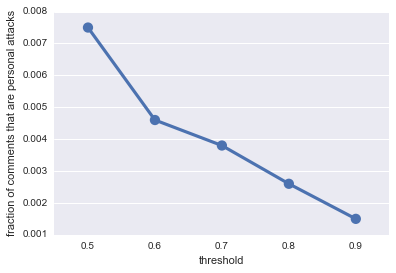

In [213]:
# score = mean of annotations
d_temp = pd.concat([pd.DataFrame({'threshold': t, 'attack': d_annotated['recipient_score'] >= t }) for t in np.arange(0.5, 0.91, 0.1)], axis = 0) 
ax = sns.pointplot(x='threshold', y= 'attack', data=d_temp, ci = None)
plt.ylabel('fraction of comments that are personal attacks')

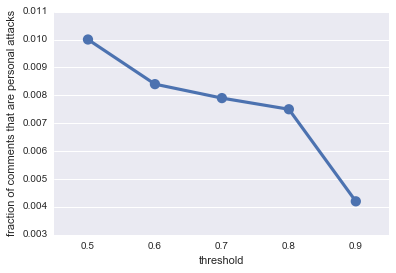

In [223]:
# score = model score on annotated data
d_temp = pd.concat([pd.DataFrame({'threshold': t, 'attack': d_annotated['pred_recipient_score'] >= t }) for t in np.arange(0.5, 0.91, 0.1)], axis = 0) 
ax = sns.pointplot(x='threshold', y= 'attack', data=d_temp, ci = None)
plt.ylabel('fraction of comments that are personal attacks')

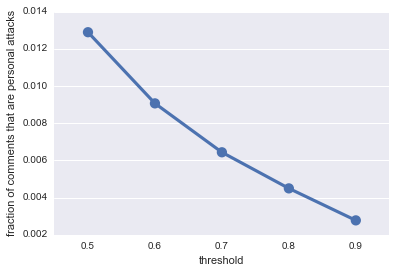

In [225]:
# score = model score on sample data
d_temp = pd.concat([pd.DataFrame({'threshold': t, 'attack': df_no_admin_sample['pred_recipient_score'] > t }) for t in np.arange(0.5, 0.91, 0.1)], axis = 0) 
ax = sns.pointplot(x='threshold', y= 'attack', data=d_temp, ci = None)
plt.ylabel('fraction of comments that are personal attacks')

### Q: What fraction of users have made a personal attack?

Methodology: Take unsampled data. Compute fraction of people who authored one comment that was predicted to be a personal attack. TODO: applying a clasifier may bias the results here, since  prolific users who are benign may get a misclassified comment with high probability.

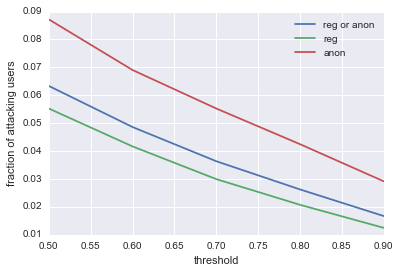

In [236]:
n_writing_users = len(df_no_admin_2015['user_text'].unique())
n_writing_anon_users = len(df_no_admin_2015.query('author_anon == True')['user_text'].unique())
n_writing_registered_users = n_writing_users - n_writing_anon_users

ts = np.arange(0.5, 0.91, 0.1)
fs = []
reg_fs = []
anon_fs = []

for t in ts:
    attacks = df_no_admin_2015[df_no_admin_2015['pred_recipient_score'] >=t]
    n_attacking_users = len(attacks['user_text'].unique())
    n_attacking_anon_users = len(attacks.query('author_anon == True')['user_text'].unique())
    n_attacking_registered_users = n_attacking_users - n_attacking_anon_users
    fs.append(((n_attacking_users/n_writing_users)))
    anon_fs.append(((n_attacking_anon_users/n_writing_anon_users)))
    reg_fs.append(((n_attacking_registered_users/n_writing_registered_users)))
plt.plot(ts, fs, label = 'reg or anon')
plt.plot(ts, reg_fs, label = 'reg')
plt.plot(ts, anon_fs, label = 'anon')
plt.legend()
plt.xlabel('threshold')
plt.ylabel('fraction of attacking users')

### Q: What fraction of attacking users have been blocked for harassment?

TODO: Also consider just registered users 

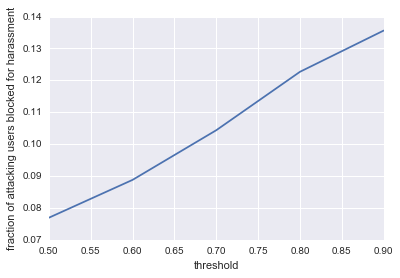

In [239]:
fs = []
blocked_users = set(df_events['user_text'].unique())
for t in ts:
    attacks = df_no_admin_2015[df_no_admin_2015['pred_recipient_score'] >=t]
    attacking_users = set(attacks['user_text'].unique())
    blocked_attacking_users = attacking_users.intersection(blocked_users)
    fs.append(len(blocked_attacking_users)/ len(attacking_users))
plt.plot(ts, fs)
plt.xlabel('threshold')
plt.ylabel('fraction of attacking users blocked for harassment')

### Q: What fraction of attacking comments come from users blocked for harassment?

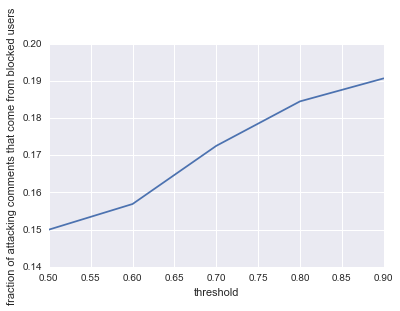

In [241]:
fs = []
for t in ts:
    attacks = df_no_admin_2015[df_no_admin_2015['pred_recipient_score'] >=t]
    n_attacking_comments = attacks.shape[0]
    n_attacking_comments_from_blocked_users = attacks.merge(df_blocked_user, how = 'inner', on = 'rev_id').shape[0]
    fs.append(n_attacking_comments_from_blocked_users/n_attacking_comments)
        
plt.plot(ts, fs)
plt.xlabel('threshold')
plt.ylabel('fraction of attacking comments that come from blocked users')

### Q: What fraction of attacking comments were followed by a block event?
Within one week

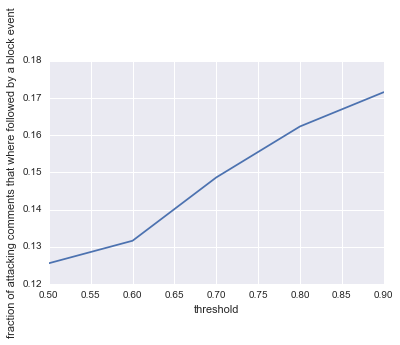

In [276]:
fs = []
for t in ts:
    attacks = df_no_admin_2015[df_no_admin_2015['pred_recipient_score'] >=t][['user_text', 'rev_id', 'rev_timestamp']]
    attacks = attacks.merge(df_events, how = 'left', on = 'user_text')
    attacks['blocked'] = (attacks['timestamp'] - attacks['rev_timestamp']) <  pd.Timedelta('7 days') 
    attacks.drop_duplicates(subset = 'rev_id', inplace = True)
    fs.append(attacks['blocked'].mean())
plt.plot(ts, fs)
plt.xlabel('threshold')
plt.ylabel('fraction of attacking comments that where followed by a block event')

### Q: How does the probablity of a user being blocked change with the number of attacking comments?

In [244]:
def remap(x):
    if x < 5:
        return str(x)
    if x < 10:
        return '5-10'
    else:
        return '10+'
dfs = []   
for t in [0.5, 0.7]:
    blocked_users = df_events[['user_text']].drop_duplicates()
    blocked_users['blocked'] = 1
    blocked_users.index = blocked_users.user_text
    attacking_users = df_no_admin_2015.query('pred_recipient_score >= %f' % t).groupby('user_text', as_index = False)['pred_recipient'].sum()
    attacking_users.index = attacking_users.user_text
    attacking_users['blocked'] = blocked_users['blocked']
    attacking_users['blocked'] = attacking_users['blocked'].fillna(0)
    attacking_users['num_attacks'] = attacking_users['pred_recipient'].apply(remap)
    attacking_users['threshold'] = t
    dfs.append(attacking_users)
    
ax = sns.pointplot(x='num_attacks', y= 'blocked', data=pd.concat(dfs), hue = 'threshold', order = ('1', '2', '3', '4', '5-10', '10+'))
plt.ylabel('fraction blocked')

### Q: What fraction of users have been attacked?

Methodology: Take unsampled data. Compute fraction of people who recieved one comment that was predicted to be a personal attack. TODO: why have there been so many more attackers and victims?

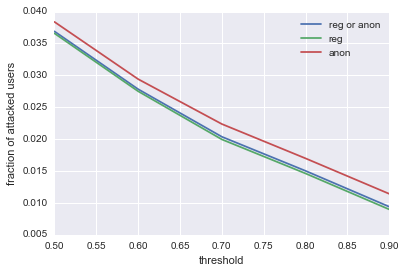

In [248]:
n_receiving_users = len(df_no_admin_2015['page_title'].unique())
n_receiving_anon_users = len(df_no_admin_2015.query('recipient_anon == True')['page_title'].unique())
n_receiving_registered_users = n_receiving_users - n_receiving_anon_users

ts = np.arange(0.5, 0.91, 0.1)
fs = []
reg_fs = []
anon_fs = []

for t in ts:
    attacks = df_no_admin_2015[df_no_admin_2015['pred_recipient_score'] >=t]
    n_attacked_users = len(attacks['page_title'].unique())
    n_attacked_anon_users = len(attacks.query('recipient_anon == True')['page_title'].unique())
    n_attacked_registered_users = n_attacked_users - n_attacked_anon_users
    fs.append(((n_attacked_users/n_receiving_users)))
    anon_fs.append(((n_attacked_anon_users/n_receiving_anon_users)))
    reg_fs.append(((n_attacked_registered_users/n_receiving_registered_users)))
plt.plot(ts, fs, label = 'reg or anon')
plt.plot(ts, reg_fs, label = 'reg')
plt.plot(ts, anon_fs, label = 'anon')
plt.legend()
plt.xlabel('threshold')
plt.ylabel('fraction of attacked users')

# Model Checking

### Q: How does the distribution over aggression scores compare across annotators vs models and different data sets

This is mainly a sanity check that the aggression model is working new data

(-3, 3)

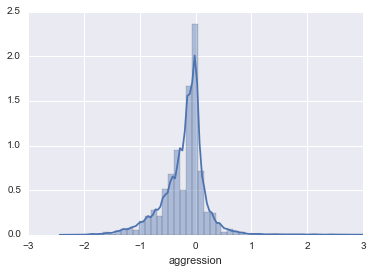

In [71]:
# annotations
sns.distplot(d_annotated['aggression'].dropna())
plt.xlim(-3, 3)

(-3, 3)

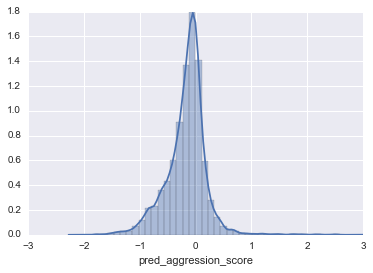

In [72]:
# model on annotated data
sns.distplot(d_annotated['pred_aggression_score'].dropna())
plt.xlim(-3, 3)

(-3, 3)

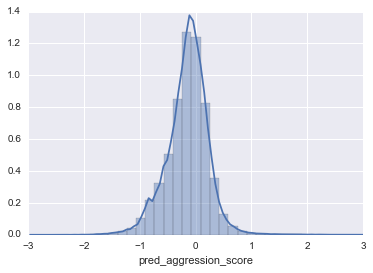

In [113]:
#model no admin sample
sns.distplot(df_no_admin_sample['pred_aggression_score'].dropna())
plt.xlim(-3, 3)

In [ ]:
#model blocked user
sns.distplot(df_no_admin_sample['pred_aggression_score'].dropna())
plt.xlim(-3, 3)

### Q: How does the distribution over attack probabilities compare across annotators vs models and different data sets

This is mainly a sanity check that the attack model is working new data

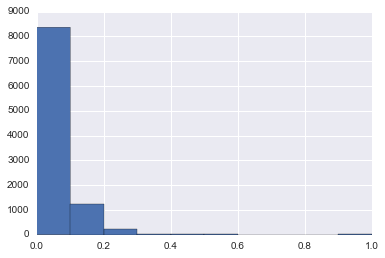

In [77]:
d_annotated['recipient_score'].hist(bins = 10) 
#sns.distplot(d_annotated['recipient_score'].dropna())

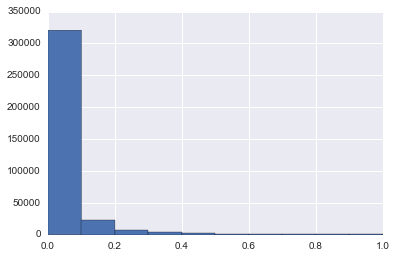

In [78]:
# curently svm scores, broken due to 
df_no_admin_sample['pred_recipient_score'].hist(bins = 10) 

### Q: How are aggression and personal attacks related? Is it just the attacks that are aggressive or are their other types if aggression?

Methodology: check pearson correlation between aggression and attack scores for sample or unsampled data.

In [79]:
d_temp = d_annotated.dropna(subset=['aggression', 'recipient_score'])
pearson(d_temp['aggression'],d_temp['recipient_score'])

0.49449657698564492

In [81]:
d_temp = d_annotated.dropna(subset=['pred_aggression_score', 'pred_recipient_score'])
pearson(d_temp['pred_aggression_score'],d_temp['pred_recipient_score'])

0.52479381001130854

In [82]:
pearson(df_no_admin_sample['pred_aggression_score'],df_no_admin_sample['pred_recipient_score'])

0.54118385618636144

### Some plotting Utils

In [83]:
def mpg(df, score, cols):
    """
    return row with max score in each group of cols values
    """
    return df.sort(score, ascending=False).groupby(cols, as_index=False).first()

def plot_scores(df, x, mpu = False, order = None, hue = None):
    
    if mpu:
        cols = ['user_text', x]
        plt.figure()
        ax = sns.pointplot(x=x, y= 'pred_aggression_score', data=mpg(df, 'pred_aggression_score', cols) , order = o, hue = hue)
        plt.figure()
        ax = sns.pointplot(x=x, y= 'pred_recipient', data=mpg(df, 'pred_recipient', cols) , order = o, hue = hue)
    else:
        plt.figure()
        ax = sns.pointplot(x=x, y= 'pred_aggression_score', data=df, order = o, hue = hue)
        plt.figure()
        ax = sns.pointplot(x=x, y= 'pred_recipient', data=df, order = o, hue = hue)
    
    

### Q: How do comments made by registered and anonymous authors compare?

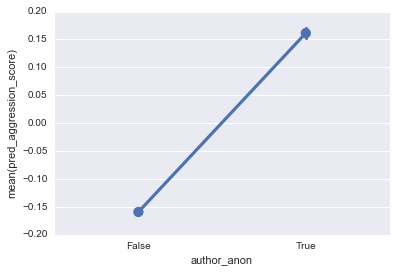

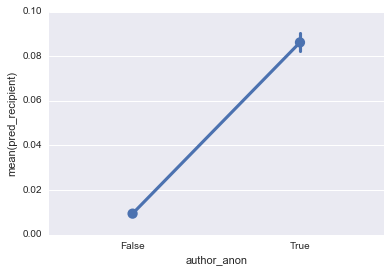

In [100]:
o = (False, True)
x = 'author_anon'
plot_scores(df_no_admin_sample, x, order = o)

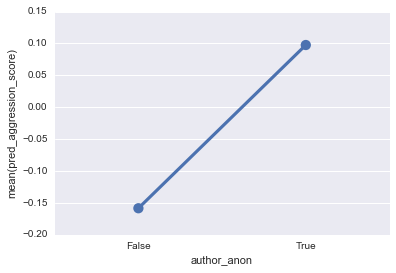

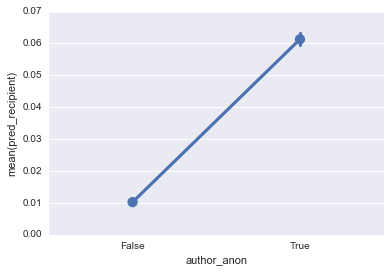

In [101]:
plot_scores(df_no_admin_2015, x, order = o)

### Q: How do comments received by registered and anonymous authors compare?

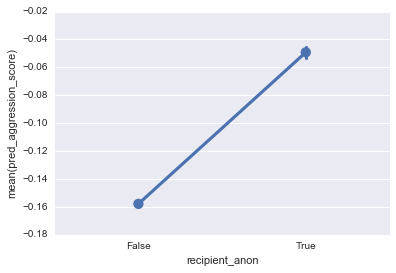

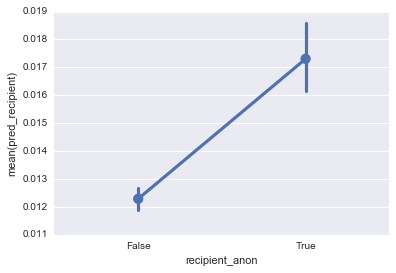

In [102]:
x = 'recipient_anon'
plot_scores(df_no_admin_sample, x, order = o)

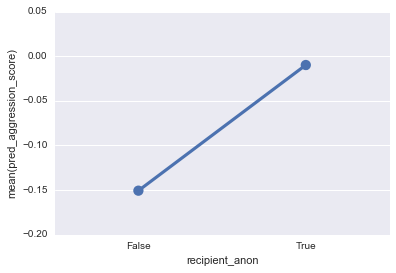

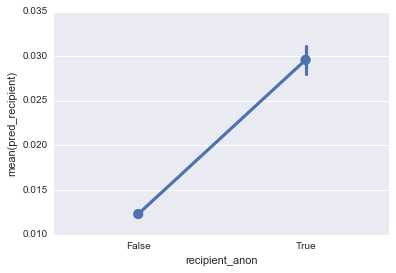

In [103]:
plot_scores(df_no_admin_2015, x, order = o)

### Q: How do authors write differently on their own page than on other pages?

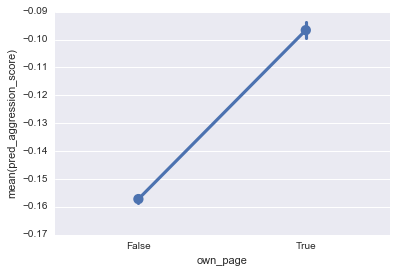

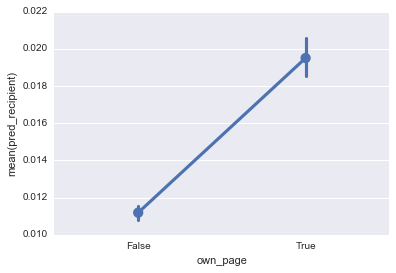

In [105]:
x = 'own_page'
df_no_admin_sample [x] = df_no_admin_sample['user_text'] == df_no_admin_sample['page_title']
df_no_admin_2015 [x] = df_no_admin_2015['user_text'] == df_no_admin_2015['page_title']

o = (False, True)
plot_scores(df_no_admin_sample, x, order = o)

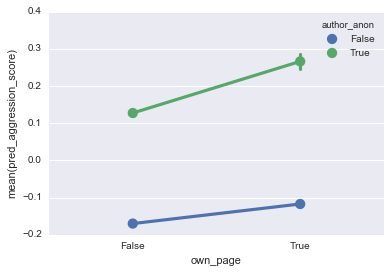

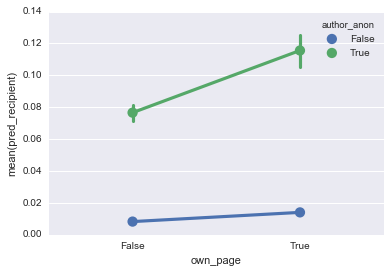

In [107]:
plot_scores(df_no_admin_sample, x, order = o, hue = 'author_anon')

### Q: Has the amount of aggressiveness and attacks changed year over year?

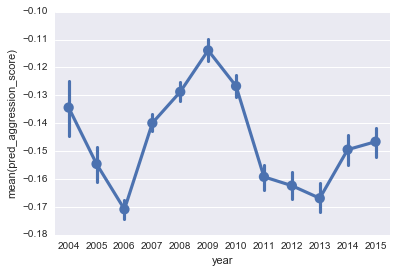

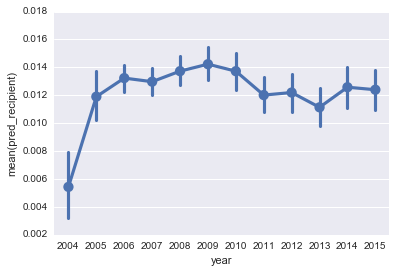

In [108]:
df_span = df_no_admin_sample.query('year > 2003 & year < 2016')
x = 'year'
o = range(2004, 2016)
plot_scores(df_span, x, order = o)

### Q: Is there a seasonal effect?

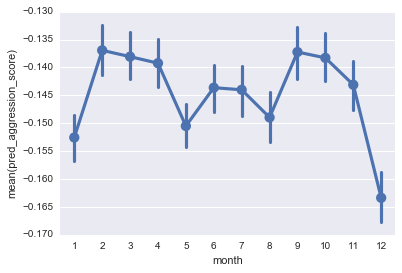

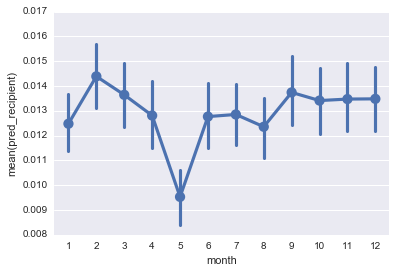

In [111]:
x = 'month'
o = range(1, 13)
plot_scores(df_no_admin_sample, x, order = o)

### Q: Is there an hour of day effect?

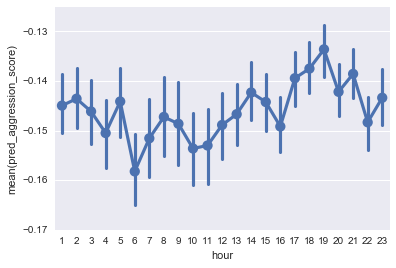

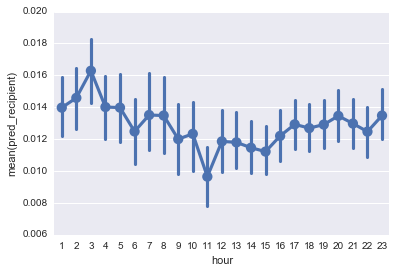

In [112]:
x = 'hour'
o  = range(1, 24)
plot_scores(df_no_admin_sample, x, order = o)